In [66]:
import numpy as np
import pandas as pd
import time
from typing import Tuple, List, Dict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

# Biased Latent Matrix Factorization under Extreme Sparsity

This notebook accompanies the project  
**“The Hunger Games: An Exploration of Ultra Sparse Rating Matrices for a Minimum Viable Biased Latent Matrix Factorization Recommender System”**.

The goal of this notebook is to provide a **computational, transparent implementation**
of the Biased Latent Matrix Factorization (BLMF) model studied in the paper, with
a focus on:
- extreme sparsity regimes
- comparison against a regularized baseline model
- clarity of optimization and training mechanics

## Why Rating Density Matters

Recommender systems rely on observed user–item interactions to learn preferences.
In ultra sparse datasets, most user–item pairs are unobserved, making it difficult
to generalize reliably.

This project investigates **how sparse a ratings matrix can become before a
Biased Latent Matrix Factorization (BLMF) model becomes ineffective**, and whether
it still outperforms a regularized baseline recommender under such conditions.


## Baseline Biased Recommender Model

The baseline model predicts ratings using global, user, and item bias terms only.

The predicted rating for user $u$ and item $i$ is:

$$
\hat{r}_{ui} = \mu + b_u + b_i
$$

where:
- $\mu$ is the global mean rating
- $b_u$ is the bias for user $u$
- $b_i$ is the bias for item $i$


## Baseline Objective Function

The baseline model is trained by minimizing the regularized squared error:

$$
\sum_{(u,i)\in D}
(r_{ui} - \mu - b_u - b_i)^2
+
\lambda \left(
\sum_u b_u^2 + \sum_i b_i^2
\right)
$$

where:
- $D$ is the set of observed ratings
- $\lambda$ controls regularization strength

Regularization shrinks bias estimates for users and items with very few ratings,
which is critical under extreme sparsity.


## From Baseline to Biased Latent Matrix Factorization (BLMF)

While the baseline model captures global tendencies, it does not model
**user–item interactions**.

Biased Latent Matrix Factorization extends the baseline by introducing
latent representations for users and items, allowing the model to learn
interaction structure beyond simple biases.


## Biased Latent Matrix Factorization Model

The BLMF prediction formula is:

$$
\hat{r}_{ui} = \mu + b_u + b_i + p_u^T q_i
$$

where:
- $p_u$ is the latent factor vector for user $u$
- $q_i$ is the latent factor vector for item $i$
- $k$ is the dimensionality of the latent space


## BLMF Objective Function

The BLMF model minimizes the following regularized loss:

$$
\min_{p_u, q_i, b_u, b_i}
\sum_{(u,i)\in K}
(r_{ui} - \mu - b_u - b_i - p_u^T q_i)^2
+
\lambda \left(
\|p_u\|^2 + \|q_i\|^2
\right)
$$

where:
- $K$ is the set of observed user–item pairs
- $\lambda$ is the L2 regularization parameter

## Optimization via Stochastic Gradient Descent

For each observed rating $(u,i)$, the prediction error is:

$$
e_{ui} = r_{ui} - \hat{r}_{ui}
$$

Latent factors are updated using SGD:

$$
p_u \leftarrow p_u + \alpha (e_{ui} q_i - \lambda p_u)
$$

$$
q_i \leftarrow q_i + \alpha (e_{ui} p_u - \lambda q_i)
$$

where $\alpha$ is the learning rate.


## Experimental Focus: Extreme Sparsity

To study the impact of sparsity:
- ratings are progressively removed while preserving at least one rating
  per user and per item
- multiple density levels are evaluated
- BLMF is compared against the baseline model at each density

This notebook focuses on **model implementation and training mechanics**,
while evaluation results are analyzed in detail in the accompanying paper.


## Interpretation and Scope

This notebook is intended to:
- demonstrate how BLMF is implemented from first principles
- highlight architectural decisions needed for ultra sparse data
- serve as a reproducible reference for the paper’s methodology

Detailed evaluation metrics (RMSE, MAE, Precision@K, Recall@K) and results
are discussed in the project report.

### Built Matrix Factorization Recommender 

In [119]:
class MF_Recommender:
    '''
    Matrix Factorization Recommender System using SGD (Stochastic Gradient Descent) 

    Model decomposes user-movie rating matrix into 2 separate lower ranked and denser matrices
    -P (User latent factors): shape (m users, k factors)
    -Q (Movie latent factors): shape (n users, k factors) 

    Predicted ratings is R_hat = P@Q.T + biases

    '''

    def __init__(self, n_factors: int, learning_rate: float, regularization: float, epochs: int, 
                 batch_size = 1024, MF_bias: bool = False, Output_Status: bool = True, use_bias: bool = True, 
                 use_latent_features: bool = True, use_content_features: bool = False):
                 
        '''
        n_factors = int # of latent factors
        learning_rate = float for the stochastic gradient descent optimization
        regularization = float (L2 regularization param to prevent overfitting)
        epochs = int # of passes through training data
        Output_Status = whether to print training progress (ALWAYS SET TO TRUE)
        use_bias = bool whether to use bias terms in the model 
        use_latent_features = bool turn model into baseline recommender
        use_content_features = bool whether to use content features (rating count, tags, etc)
        '''
    
        #initialization vals
        self.n_factors = n_factors #k latent factors
        self.learning_rate = learning_rate #.01 float
        self.regularization = regularization #.01 float
        self.epochs = epochs  #int
        self.Output_Status = True #ALWAYS SET TO TRUE
        self.use_bias = use_bias #T/F
        self.use_latent_features = use_latent_features #T/F
        self.use_content_features = use_content_features #T/F
        self.batch_size = batch_size
        self.MF_bias = MF_bias
        '''
        user_factors = P matrix: user latent factors
        movie_factors = Q matrix: movie latent factors
        user_biases = user bias term
        movie_biases = movie bias term
        global_mean = global mean rating
        user_content_weights = use in Hybrid model 
        movie_content_weights = use in Hybrid model
    
        '''
        #model params
    
        self.user_factors = None #P matrix: user latent factors
        self.movie_factors = None #Q matrix: movie latent factors
        self.user_biases = None #user bias terms
        self.movie_biases = None #movie bias terms
        self.global_mean = None #global mean rating
        
        self.global_mean_bias = None
    
        #For hybrid model
        self.user_content_weights = None 
        self.movie_content_weights = None
        
        #Map for movie/user for matrix
        self.user_id_to_idx = {}
        self.movie_id_to_idx = {}
        self.idx_to_user_id = {}
        self.idx_to_movie_id = {}
        self.movie_id_to_name = {}

        self.user_id_to_user_mean = {}
        self.movie_id_to_movie_mean = {}
        
        #training history
        self.train_losses = []
        self.train_mae_losses = []
        self.val_losses = []
        self.val_mae_losses = []

        #to keep track of example users for spot check
        self.examples_list = []
        
        #evaluation
        self.precision_at_k = None
        self.recall_at_k = None
        
    def initialize_model_params(self, users: int, movies: int, user_features: int = 0, movie_features: int = 0):
        '''
        Initialize the parameters for the model with near 0 values to make 
        sure model doesn't have dead gradients
    
        users: number of users
        movies: number of movies
        user_features: number of user features (may not have any)
        movie_features: number of movie features (may not have any)
        '''
        if self.use_latent_features == True:
            self.user_factors = np.random.normal(0, .001, (users, self.n_factors)) #mean 0, std of .001
            self.movie_factors = np.random.normal(0, .001, (movies, self.n_factors)) #mean 0, std of .001

        else: ############### remove logic if it breaks #######################
            self.user_factors = np.random.normal(0, 0.0, (users, self.n_factors))
            self.movie_factors = np.random.normal(0, 0.0, (movies, self.n_factors))
            
        if self.use_bias == True:
            #print("I'm in use bias")
            #initialize bias to 0 for users and movies
            self.user_biases = np.zeros(users)
            self.movie_biases = np.zeros(movies)
    
        if self.use_content_features == True: 
            #initialize content feature weights
            #in hybrid model will interact with latent features
            if user_features > 0: 
                self.user_content_weights = np.random.normal(0, .001, (user_features, self.n_factors))
            if movie_features > 0: 
                self.movie_content_weights = np.random.normal(0, .001, (movie_features, self.n_factors))
                
    def initialize_mappings(self, user_ids: np.ndarray, movie_ids: np.ndarray):
        '''
        The engine that makes the matrix factorization memory and computationally efficient
    
        user_ids: numpy array of unique user_ids
        movie_ids: numpy array of unique movie_ids
        
        '''
        #make the mapping for users go forward and backwards for faster search
        for idx, user_id in enumerate(np.unique(user_ids)):
            self.user_id_to_idx[user_id] = idx
            self.idx_to_user_id[idx] = user_id
        
        #make the mapping for movies go forward and backwards for faster search
        for idx, movie_id in enumerate(np.unique(movie_ids)):
            self.movie_id_to_idx[movie_id] = idx
            self.idx_to_movie_id[idx] = movie_id 

    def map_movie_to_names(self, movies_df):
        '''
        map movie Id to Name for ease of recognizing movie names

        '''
        
        self.movie_id_to_name = movies_df.set_index('movieId')['title'].to_dict()

        

        
    def get_content_features(self, ratings_df: pd.DataFrame, tags_df):
        '''
        To be completed later
        '''


    def predict_single_rating(self, user_idx: int, movie_idx: int, user_features= None, movie_features= None) -> float:
        '''
        SGD and any predictions cannot be trained in batches so each individual 
        user movie combo must be trained sequentially. Testing can be predicted 
        in batches and vectorized, though. 
    
        Predict single rating for user-movie pair
    
        Vanilla MF:
        rating = global mean + user bias + movie bias + user factors @ movie factors.T
    
        Hybrid model: 
        rating += (user features @ user content weights) @ (movie features @ movie content weights).T
    
        user_idx: int. user index in matrix
        movie_idx: int. movie index in matrix
    
        for Hybrid Model
        user_features: numpy array. user content features
    
        movie features: numpy array. movie content features
    
        returns float prediction for user movie combo
        '''
    
        prediction = self.global_mean
    
        #if self.user_biases is None and movie_biases is None:
        #    user_biases = np.zeros(users)
        #    movie_biases = np.zeros(movies)
        #add bias if used
        if self.use_bias == True: 
            prediction += self.user_biases[user_idx] + self.movie_biases[movie_idx]

        if self.use_latent_features == True: 
            #add latent factors
            prediction += self.user_factors[user_idx]@self.movie_factors[movie_idx]
    
        #add content features for hybrid model if used
        if self.use_content_features == True and user_features is not None and movie_features is not None: 
            #to be filled later
            1
            
        return prediction

    def SGD(self, user_idx: int, movie_idx: int, rating: float, user_features= None, movie_features= None):
        '''
        perform a single SGD update for one user-movie rating
    
        user_idx: int. User index in the matrix
        movie_idx: int. Movie index in the matrix
        rating: float. Actual movie rating
    
        Hybrid Model
        user_features: numpy array. User Content features
        movie_features: numpy array. Movie Content features
        '''
    
        #calculate prediciton error
        prediction = self.predict_single_rating(user_idx, movie_idx, user_features, movie_features)
        prediction_error = rating - prediction
    
        #store old values to update all simultaneously
        old_user_factors = self.user_factors[user_idx].copy()
        old_movie_factors = self.movie_factors[movie_idx].copy()
    
        #update latent factors using gradient descent
        self.user_factors[user_idx] += self.learning_rate * (prediction_error * old_movie_factors - self.regularization * old_user_factors)
    
        self.movie_factors[movie_idx] += self.learning_rate * (prediction_error * old_user_factors - self.regularization * old_movie_factors)
    
        #update biases if used
        if self.use_bias == True: 
            ############################################ Check ##################
            #may turn off if the bias update doesn't need regularization
            ####################################################################
            self.user_biases[user_idx] += self.learning_rate * prediction_error
            self.movie_biases[movie_idx] += self.learning_rate * prediction_error
    
        #update content feature weights for Hybrid model
        if self.use_content_features == True and user_features is not None and movie_features is not None: 
            1

    def fit_model(self, ratings_df: pd.DataFrame, tags_df: None, val_split: float=.2):
        '''
        Train the MF model using SGD
    
        ratings_df: the ratings dataframe
        tags_df: the tags for the hybrid model
        val_split: float. the percent split for data validation
        
        '''
        
        #create train/validation split
        train_df, val_df = train_test_split(ratings_df, test_size=val_split, random_state = 158)
    
        #create user/movie mappings
        self.initialize_mappings(ratings_df['userId'].values, ratings_df['movieId'].values)
    
        #get global mean
        self.global_mean = train_df['rating'].mean() 
        
        
        #get content features for hybrid model
        user_features = None
        movie_features = None
        if self.use_content_features == True:
            1
        else:
            user_features = 0
            movie_features = 0
        
        #initialize parameters of model
        total_users = len(self.user_id_to_idx)
        total_movies = len(self.movie_id_to_idx)
        self.initialize_model_params(total_users, total_movies, user_features, movie_features)

        ###################### MINI BATCH SGD ###################
        
        user_indices = np.array([self.user_id_to_idx[uid] for uid in train_df['userId'].values])
        movie_indices = np.array([self.movie_id_to_idx[mid] for mid in train_df['movieId'].values])
        ratings = train_df['rating'].values
        
        len_ratings = len(ratings)
        
        n_batches = (len_ratings + self.batch_size - 1)// self.batch_size #make mini batches
    
        #start training
        if self.Output_Status == True: 
            print(f'Training started with Mini Batch SGD (batch size={self.batch_size})')
            print(f'Data has {total_users} Total Users, {total_movies} Total movies, and {self.n_factors} K dimensions')
            print(f'Total Epochs is {self.epochs}, Learning rate is {self.learning_rate}, and {n_batches} batches per epoch')
            print('')

        epoch_mae_loss = []
        epoch_loss = [] 
        
        start = time.time()
        
        for epoch in range(self.epochs):
            #randomize the data for sgd
            #shuffled_training_data = train_df.sample(frac=1, random_state=epoch)
            if (epoch % 10 == 0 or epoch == self.epochs -1 ):
                print(f'Starting fit for epoch {epoch+1}/{self.epochs}')
            
            indices = np.random.permutation(len_ratings)
            user_indices_shuffled = user_indices[indices]
            movie_indices_shuffled = movie_indices[indices]
            ratings_shuffled = ratings[indices]

            total_mae_loss = 0
            total_loss = 0 

            #### implement Mini batch SGD 
            for batch_begin in range(0, len_ratings, self.batch_size):
                batch_end = min(batch_begin + self.batch_size, len_ratings)

                batch_users = user_indices_shuffled[batch_begin:batch_end]
                batch_movies = movie_indices_shuffled[batch_begin:batch_end]
                batch_ratings = ratings_shuffled[batch_begin:batch_end]

                #vectorize the predictions for batch
                prediction = (self.global_mean + self.user_biases[batch_users] + self.movie_biases[batch_movies])

                #dot product
                for i in range(len(batch_users)):
                    prediction[i] += self.user_factors[batch_users[i]]@self.movie_factors[batch_movies[i]]

                #calculate error for batches
                batch_error = batch_ratings - prediction

                #calc mae loss
                total_mae_loss += np.sum(np.absolute(batch_error))
                
                total_loss += np.sum(batch_error ** 2)

                #vectorize the updates
                for i in range(len(batch_users)):
                    u_idx = batch_users[i]
                    m_idx = batch_movies[i]
                    error = batch_error[i]

                    #update with momentum
                    u_grad = error * self.movie_factors[m_idx] - self.regularization * self.user_factors[u_idx]
                    m_grad = error * self.user_factors[u_idx] - self.regularization * self.movie_factors[m_idx]

                    self.user_factors[u_idx] += self.learning_rate * u_grad
                    self.movie_factors[m_idx] += self.learning_rate * m_grad
                    self.user_biases[u_idx] += self.learning_rate * error 
                    self.movie_biases[m_idx] += self.learning_rate * error

            #calculate loss
            mae = ((1.0 * total_mae_loss)/ len_ratings)
            rmse = np.sqrt(total_loss / len_ratings)

            epoch_mae_loss.append(mae)
            epoch_loss.append(rmse)
            if (epoch % 10 == 0 or epoch == self.epochs -1 ):
                print(f'Finished fitting Epoch {epoch+1}')
            
            
        #Calc epoch loss metrics
        epoch_mae_train_loss = np.mean(epoch_mae_loss)
        epoch_train_loss = np.mean(epoch_loss)
        self.train_mae_losses.append(epoch_mae_train_loss)
        self.train_losses.append(epoch_train_loss)


        end = time.time()

        print(f'Finished all Epochs. Total time elapsed {(end - start)/60 : .2f} minutes')
        
        #validation set loss calculations
        val_predictions = []
        val_actual = []
        for _, row in val_df.iterrows():
            if row['userId'] in self.user_id_to_idx and row['movieId'] in self.movie_id_to_idx:
                user_idx = self.user_id_to_idx[row['userId']]
                movie_idx = self.movie_id_to_idx[row['movieId']]
                v_prediction = self.predict_single_rating(user_idx, movie_idx, user_features, movie_features)
                val_predictions.append(v_prediction)
                val_actual.append(row['rating'])
    
        val_rmse_loss = mean_squared_error(val_actual, val_predictions)
        val_mae_loss = mean_absolute_error(val_actual, val_predictions)
        
        self.val_losses.append(val_rmse_loss)
        self.val_mae_losses.append(val_mae_loss)
    
        #update learning rate automatically (may be useful)
        #if epoch %10 == 0 and epoch > 0: 
        #    learning_rate *= .9

        end2 = time.time()
        print(f'Finished fitting. Total time elapsed {(end2 - start)/60 : .2f} minutes')
        
        #show progress on epochs
        if self.Output_Status == True and (epoch % 10 == 0 or epoch == self.epochs -1 ):
            print(f'Epoch {epoch + 1}/{self.epochs}: Training RMSE loss is {epoch_train_loss: .6f} and Validation RMSE loss is {val_rmse_loss: .6f}')
            print(f'Training MAE loss is {epoch_mae_train_loss: .6f} and Validation MAE loss is {val_mae_loss: .6f}')
            
    def predict_for_batch(self, user_ids:  np.ndarray, movie_ids: np.ndarray) -> np.ndarray:
        '''
        Prediction for batchs of user-movies combos. Includes code to remove cold start problem results
    
        user_ids: numpy array of user Ids
        movie_ids: numpy array of movie Ids
    
        return: numpy array of predicted ratings
        '''

        ############################### 

        '''
        ### Remove invalid movie ratings #####
        #  create a set of missing movies not in training
        missing_movies = set(df['movieId']) - set(train_df['movieId'])
        if missing_movies: # if we have missing movies
            # Add one random row per missing movie
            movies_to_add = (df[df['movieId'].isin(missing_movies)] # create the filtered df
                .groupby('movieId', as_index=False, sort=False) # group by movie id
                .apply(lambda x: x.sample(1, random_state=random_state)) # grab one sample from each group
                .reset_index(drop=True))
            # concat with the training set, we might have duplicates on the test set
        train_df = pd.concat([train_df, movies_to_add], ignore_index=True)
        '''
        #if user/movie in test did not appear in train, have handler
        valid_boolean_mask = np.array([uid in self.user_id_to_idx and mid in self.movie_id_to_idx
                                       for uid, mid in zip(user_ids, movie_ids)])

        predictions = np.full(len(user_ids), self.global_mean)

        #if there are no valid user/movies
        if not np.any(valid_boolean_mask):
            return predictions

        #get valid user/movie Ids
        valid_user_ids = user_ids[valid_boolean_mask]
        valid_movie_ids = movie_ids[valid_boolean_mask]

        #convert to indices 
        user_indices = np.array([self.user_id_to_idx[uid] for uid in valid_user_ids])
        movie_indices = np.array([self.movie_id_to_idx[mid] for mid in valid_movie_ids])

        #vectorized prediction computation 
        valid_predictions = np.full(len(user_indices), self.global_mean)
        
        if self.use_bias ==True: 
            #vectorized biases are added
            valid_predictions += self.user_biases[user_indices]
            valid_predictions += self.movie_biases[movie_indices]

        if self.use_latent_features == True:
        #apparently einsum is especially well built for computing batch dot products with shifting dimensions
            latent_predictions = np.einsum('ij, ij->i', 
                                        self.user_factors[user_indices], 
                                        self.movie_factors[movie_indices])

            valid_predictions += latent_predictions

        #user boolean mask to output only valid predictions
        predictions[valid_boolean_mask] = valid_predictions

        
        return predictions

    
        
    def predict_for_bias(self, ratings_train_biased_df: pd.DataFrame, user_ids:  np.ndarray, movie_ids: np.ndarray) -> np.ndarray:
    
    
        # sending the ratings train df user id and movie id values to be mapped
        self.initialize_mappings(ratings_train_biased_df['userId'].values, ratings_train_biased_df['movieId'].values)
        self.global_mean = ratings_train_biased_df['rating'].mean()
        
        if self.regularization > 0:
            self.regularize_biases(ratings_train_df)
        else:
            user_mean = ratings_train_df.groupby('userId')['rating'].mean() - self.global_mean
            movie_mean = ratings_train_df.groupby('movieId')['rating'].mean() - self.global_mean
    
            self.user_id_to_user_mean = user_mean.to_dict()
            self.movie_id_to_movie_mean = movie_mean.to_dict()
        
        
        
        user_mean = ratings_train_biased_df.groupby('userId')['rating'].mean().rename('user_mean')
        movie_mean = ratings_train_biased_df.groupby('movieId')['rating'].mean().rename('movie_mean')
        
        self.user_id_to_user_mean = user_mean.to_dict()
        self.movie_id_to_movie_mean = movie_mean.to_dict()
    
        #if user/movie in test did not appear in train, have handler

        # zip(user_id,movie_id): pairs the elements as (u1,m1),(u2,m2)
        # for each element inside the zip pair for every pair
        #  is user in self dictionary of user indices? movie in self dictionary of movie indices?
        
        valid_boolean_mask = np.array([uid in self.user_id_to_idx and mid in self.movie_id_to_idx
                                       for uid, mid in zip(user_ids, movie_ids)])

        
        # np.full(n, value), creates an np array of length n, filled with 'value'
        # np array of length user id with global means, every user has global mean
        predictions = np.full(len(user_ids), self.global_mean)

        #if there are no valid user/movies
        # if we dont have True value on the boolean mask, meaning if we dont have test users that also are in training
        if not np.any(valid_boolean_mask):
            print("neither element of the user-movie pair from test_df for all pairs, appear on the training")
            return predictions # global_mean

        
        ##### REAL PREDICTION PROCESS ####
        
        #get valid user/movie Ids
        # mask the test user id with valid boolean mask and have only the valid user id
        valid_user_ids = user_ids[valid_boolean_mask]
        valid_movie_ids = movie_ids[valid_boolean_mask]
        
       
        
        
        
        #  STEP: global mean + user bias + movie bias
   
        user_means = np.array([self.user_id_to_user_mean[uid] for uid in valid_user_ids])
        movie_means = np.array([self.movie_id_to_movie_mean[mid] for mid in valid_movie_ids])
    
        valid_predictions = user_means + movie_means - self.global_mean

        #user boolean mask to output  valid predictions and prediction with global mean
        predictions[valid_boolean_mask] = valid_predictions

        return predictions

    def regularize_biases(self, ratings_train_df):
        """
        Regularizes user and movie biases using shrinkage to the MF.
        Saves results into:
          self.user_id_to_user_mean
          self.movie_id_to_movie_mean
        """
    
        lambdaa = self.regularization   # use class regularization 
        self.global_mean = ratings_train_df['rating'].mean()
    
        # series of group users and movies 
        user_groups = ratings_train_df.groupby('userId')['rating']
        movie_groups = ratings_train_df.groupby('movieId')['rating']
    
        # starting bias =  (user_mean - globa_mean)
        b_u = (user_groups.mean() - self.global_mean).to_dict()
        b_i = (movie_groups.mean() - self.global_mean).to_dict()
    
        # update biases do 5 loops
        for _ in range(5):  
            # update users
            for u in b_u.keys():
                #grab the rows for that user from the train df
                user_rows = ratings_train_df[ratings_train_df['userId'] == u]
                # row count of user_rows will give us the rating count of that user
                N_u = len(user_rows)
                # if user is not in training, just security measure, skip no ratings
                if N_u == 0:
                    continue
                    # sum  of every user rating as so:
                # (r_{ui} - u - b_i = rating of user on movie i - global mean - movie_i mean) 
                sum_numerator = 0.0
                for _, row in user_rows.iterrows():
                    i = row['movieId']
                    r_ui = row['rating']
                    sum_numerator += (r_ui - self.global_mean - b_i.get(i, 0))
                # user bias formula, sum of every user rating/ penalty + user rating count
                b_u[u] = sum_numerator / (lambdaa + N_u)
    
            # update movies same as users, get users, set Ni, skip no ratings,numerator
            for i in b_i.keys():
                movie_rows = ratings_train_df[ratings_train_df['movieId'] == i]
                N_i = len(movie_rows)
                if N_i == 0:
                    continue
                    # sum  of every user rating as so:
                # (r_{ui} - u - b_i = rating of user on movie i - global mean - movie_i mean)   
                sum_numerator = 0.0
                for _, row in movie_rows.iterrows():
                    u = row['userId']
                    r_ui = row['rating']
                    # (r_{ui} - u - b_u = rating of user on movie i - global mean - user_ mean) 
                    sum_numerator += (r_ui - self.global_mean - b_u.get(u, 0))
                # movie bias formula, sum of every movie rating/ penalty + movie rating count
                b_i[i] = sum_numerator / (lambdaa + N_i)
    
        # save the biases
        self.user_id_to_user_mean = b_u
        self.movie_id_to_movie_mean = b_i    

    def recommend_movies(self, user_id: int, n_recommendations: int=3, 
                         exclude_already_watched: bool = True, already_watched = None) -> List[Tuple[int, float]]:
        '''
        Make the top N recommendations for any given user
        '''
        #edge case in case its a new user
        #if user_id not in user_id_to_idx: 
        #    return []

        if user_id not in self.user_id_to_idx:
            #print("Not in user_id_to_idx")
            return []
        
        user_idx = self.user_id_to_idx[user_id]
    
        #generate predictions for all movies
        movie_predictions = []
        for movie_id, movie_idx in self.movie_id_to_idx.items():
            #skip if excluding movies already watched
            if exclude_already_watched == True and already_watched and movie_id in already_watched: 
                continue
    
            pred = self.predict_single_rating(user_idx, movie_idx)
            movie_predictions.append((movie_id, pred))
    
        #sort by predicted rating (descending order) and return top N 
        movie_predictions.sort(key = lambda x: x[1], reverse = True)
        return movie_predictions[:n_recommendations]

    def simple_evaluation(self, test_set, ratings_train_biased_df = None):
        user_ids, movie_ids = test_set['userId'], test_set['movieId']
        #make predictions
        
        if self.MF_bias:
            #self.global_mean_bias = ratings_df['rating'].mean()
            v_mf_predictions = self.predict_for_bias(ratings_train_biased_df,user_ids, movie_ids)
        else:
            v_mf_predictions = self.predict_for_batch(user_ids, movie_ids)
        
        #limit range of predictions to only be between .5-5.0
        v_mf_predictions = np.clip(v_mf_predictions, .5, 5.0)
        
        #pull actual test ratings
        test_actual_ratings = test_set['rating'].values
        
        rmse = np.sqrt(mean_squared_error(test_actual_ratings, v_mf_predictions))
        mae = mean_absolute_error(test_actual_ratings, v_mf_predictions)
        
        #calculate errors
        errors = test_actual_ratings, v_mf_predictions
        bias = np.mean(errors)
        variance = np.var(errors)
        
        #  % of predictions that were close
        within_half_star = np.mean(np.absolute(errors) <= .5) * 100
        within_one_star = np.mean(np.absolute(errors) <= 1.0) * 100
        
        #coverage
        #if self.use_latent_features == True and self.MF_bias == False:
        coverage = np.mean(v_mf_predictions != self.global_mean) * 100

        #else:# self.use_latent_features == False and self.MF_bias == False:
            #print(f'v_mf_predictions is {v_mf_predictions}')
            #print(f'self.global_mean_bias is {self.global_mean_bias}')
            #coverage = np.mean(v_mf_predictions != self.global_mean_bias) * 100
        
        metrics = {
                'rmse': rmse,
                'mae': mae,
                'bias': bias, 
                'variance': variance,
                'within_half_star': within_half_star,
                'within_one_star': within_one_star, 
                'coverage': coverage, 
        }
        
        return metrics

    def set_sparsity(self, full_dataset, sparsity_amt: float):

        unique_users = full_dataset['userId'].nunique()
        unique_movies = full_dataset['movieId'].nunique()
        total_ratings = full_dataset.shape[0] #first value is total number of rows (ratings)
        
        current_density = (total_ratings * 1.0)/(unique_users * unique_movies)
        print(f'Unique users: {unique_users}, Unique Movies: {unique_movies}, Total Ratings: {total_ratings}')
        print(f'Current_density is {current_density}')

        #check that sparsity is less than new amount
        if sparsity_amt > current_density:
            print('Sparsity amt is greater than current Matrix size')
            return None

        #check that the sparsity is greater than the theoretical minimum sparsity possible
        min_ratings_theoretical_min = max(unique_users, unique_movies)
        min_sparsity = (min_ratings_theoretical_min*1.0)/ (unique_users * unique_movies)

        if sparsity_amt < min_sparsity:
            print(f'Sparsity amt {sparsity_amt} is too low. Minimum theoretical sparsity is {min_sparsity} to keep all users/movies')
            return None
        
        target_ratings = int(sparsity_amt * unique_users * unique_movies)
        ratings_to_remove = total_ratings - target_ratings

        updated_full_dataset = full_dataset[['userId', 'movieId', 'rating']].reset_index(drop=True)
        users = updated_full_dataset['userId'].values
        movies = updated_full_dataset['movieId'].values
        total_size = total_ratings

        #get Ids in order to reduce lookups
        _, user_inverted_id = np.unique(users, return_inverse=True)
        _, movie_inverted_id = np.unique(movies, return_inverse=True)

        #count frequency of inverted ids
        useridx_freq = np.bincount(user_inverted_id)
        movieidx_freq = np.bincount(movie_inverted_id)

        #boolean mask for the ratings to preserve
        ratings_bool_mask = np.ones(total_size, dtype=bool)
        #shuffle indices for random removal
        indices = np.arange(total_size)
        randomizer = np.random.RandomState(158)
        randomizer.shuffle(indices)

        #start removing ratings
        removed_ratings = 0
        for idx in indices:
            if removed_ratings >= ratings_to_remove:
                break

            u_idx = user_inverted_id[idx]
            m_idx = movie_inverted_id[idx]

            #remove as long as movie and user still have at least 1 rating
            if useridx_freq[u_idx] >= 2 and movieidx_freq[m_idx] >= 2:
                #update boolean mask to keep track of changes
                ratings_bool_mask[idx] = False
                #decrement counts
                useridx_freq[u_idx] -= 1
                movieidx_freq[m_idx] -= 1
                #increase count of removed ratings
                removed_ratings += 1

        final_ratings = total_size - removed_ratings
        final_sparsity = final_ratings / (unique_users * unique_movies)
        
        if removed_ratings < ratings_to_remove:
            print(f'Could not achieve the sparsity targeted {sparsity_amt}, but achieved sparsity of {final_sparsity: .6f}')
            print(f'Too many ratings would have caused movies/users to disappear from dataset')

        final_sparse_dataset = updated_full_dataset[ratings_bool_mask].reset_index(drop=True)
        print(f'Achieved sparsity of {final_sparsity: .6f}')
        return final_sparse_dataset

    def get_relevant_movies(self, dataset, threshold: float) -> Dict[int, set]:
        '''
        Get all movies that are >= the threshold for relevant movies

        '''

        '''
        #print("I am in get relevant movies")
        relevant = dataset[dataset['rating'] >= threshold]

        #convert to set for faster compute and comparison
        relevant_movies = (relevant.groupby('userId')['movieId'].apply(set).to_dict())

        return defaultdict(set, relevant_movies)
        '''
        relevant = dataset[dataset['rating'] >= threshold]
        relevant_movies_dict = defaultdict(set)
        for _, row in relevant.iterrows():
            if row['movieId'] in self.movie_id_to_idx:
                relevant_movies_dict[row['userId']].add(row['movieId'])

        return relevant_movies_dict

        

    def get_watched_movies(self, dataset) -> Dict[int, List[int]]:
        '''
        Get all the movies that all users have already watched from the dataset
        
        
        watched = dataset.groupby('userId')['movieId'].apply(list).to_dict()
        
        return defaultdict(list, watched)
        '''
        watched_movies_dict = defaultdict(set)
        for _, row in dataset.iterrows():
            if row['movieId'] in self.movie_id_to_idx:
                watched_movies_dict[row['userId']].add(row['movieId'])

        return watched_movies_dict

        
        
    def Precision_And_Recall_At_K(self, test_ratings_df, 
                                  train_ratings_df, num_recommendations, 
                                  relevance_threshold, 
                                  num_of_examples: int = 5):

        '''
        Calculate precision and recall and output a few examples to spot check and verify results


        '''

        #set random seed for random examples pulled
        np.random.seed(158)

        #get all unique users from test set
        all_test_users = test_ratings_df['userId'].unique()

        #get all unique training users for comparison. Sets make comparison functions faster
        all_train_users = set(train_ratings_df['userId'].unique())

        #get all movies from training_set
        num_of_movies = train_ratings_df['movieId'].nunique()


        #reverse the mapping of movies to indices so that examples are readable
        #idx_to_movie = {v: k for k, v in movie_id_map.items()} use self.idx_to_movie_id

        #get all valid users if they are in train and test set and in user_id mapping
        valid_counter = 0
        valid_users = []
        
        for u_id in all_test_users:
            if u_id in all_train_users and u_id in self.user_id_to_idx:
                #print(u_id)
                valid_users.append(u_id)
                valid_counter += 1

        valid_users = np.array(valid_users)

        if len(valid_users) == 0: 
            return 'No valid users found in both the train and test set with correct user Id mapping'

        #now get RANDOM example users from this set of valid users
        sample_example_ct = min (num_of_examples, len(valid_users))
        sample_example_idx = np.random.choice(len(valid_users), size = sample_example_ct, replace = False)
        sample_examples = set(valid_users[sample_example_idx])
        print(f'The sample of users we are looking at is {sample_examples}. There are {len(sample_examples)} total users in this sample')
        #Pre compute and get all movies that are relevant for the users in the test set
        relevant_movies = self.get_relevant_movies(test_ratings_df, relevance_threshold)

        #pre compute all test movies by user so that we can output the example movies that were rated
        all_test_movies_dict = defaultdict(dict)
        for _, row in test_ratings_df.iterrows():
            all_test_movies_dict[row['userId']][row['movieId']] = row['rating']

        #pre compute watched movies by user from the training set
        already_watched_dict = self.get_watched_movies(train_ratings_df)

        
        user_precisions_list = []
        user_recalls_list = []
        invalid_users = {'not_in_train': 0, 'not_in_userId_to_idx': 0}

        
        all_user_ct = len(all_test_users)
        user_counter = 0
        missing_user_counter = 0

        start_time = time.time()
        
        for user in all_test_users:

            #get all user's specific relevant movies 
            user_relevant_movies = relevant_movies[user]
            
            #get each individual users list of movies that are already watched
            user_watched_movies = already_watched_dict[user]

            #get movie recommendations for user
            user_recommended_movies = self.recommend_movies( user_id= user, n_recommendations =  num_recommendations, 
                         exclude_already_watched = True, already_watched = user_watched_movies)
            
                          
            if not user_recommended_movies:
                #user_precisions_list.append(0.0)
                user_counter += 1
                missing_user_counter += 1
                #if user_relevant_movies:
                    #user_recalls_list.append(0.0)
                continue

            #get recommended movie Ids
            recommended_movieIds = {movie_id for movie_id, _ in user_recommended_movies[:num_recommendations]}

            # count all movies that were relevant AND recommended
            recommendation_hits = len(recommended_movieIds & user_relevant_movies)
            
            #Precision@K formula = (relevant and recommended movies intersection)/num recommendations
            user_precisions_list.append((1.0 * recommendation_hits)/num_recommendations)

            if user_relevant_movies: 
                #Recall@K formula = (relevant and recommended movies intersection)/all relevant movies
                user_recalls_list.append((1.0* recommendation_hits)/len(user_relevant_movies))

            #build example set
            if user in sample_examples:
                example = {
                    'userId': user, 
                    'in_train_set': True,
                    'in_test_set': True, 
                    'in_userId_to_idx': True, 
                    'precision': ((1.0 * recommendation_hits)/num_recommendations), #user precision
                    'recall': ((1.0* recommendation_hits)/len(user_relevant_movies)) if len(user_relevant_movies) > 0 else 0,                                     
                    'num_of_hits': recommendation_hits,
                    'num_of_relevant_in_test': len(user_relevant_movies), 
                    'num_movies_watched_in_train': len(user_watched_movies),
                    #recommended results
                    'top_k_recommendations': [{
                        'rank': i + 1, 
                        'movie_id': movie_id,
                        'movie_name': self.movie_id_to_name[movie_id],
                        'predicted_score': round(pred, 3),
                        'is_hit': movie_id in (recommended_movieIds & user_relevant_movies)
                    } for i, (movie_id, pred) in enumerate(user_recommended_movies)
                    ], 
                    #actual results
                    'relevant_movies_in_test':[{
                        'movie_id': movie_id, 
                        'movie_name': self.movie_id_to_name[movie_id],
                        'actual_rating': all_test_movies_dict[user].get(movie_id),
                        'was_recommended': movie_id in recommended_movieIds
                    } for movie_id in sorted(user_relevant_movies)
                    ],
                    'sample_of_movies_watched_in_train': list(user_watched_movies)[:10]
                }
                self.examples_list.append(example)
            if user_counter % 5000 == 0:
                print(f'Finished {user_counter} users out of {all_user_ct} with {missing_user_counter} missing users')

            user_counter += 1
        avg_precision_at_K = np.mean(user_precisions_list) if user_precisions_list else 0.0
        avg_recall_at_K = np.mean(user_recalls_list) if user_recalls_list else 0.0

        end_time = time.time()
        print(f'Time elapsed for Precision@K and Recall@K is {(end_time - start_time)/60} minutes')
        print(f'Found {len(user_precisions_list)} users who we predicted movies for out of {all_user_ct} total test users')
        
        return {'avg_precision': avg_precision_at_K, 'avg_recall': avg_recall_at_K}

    def create_rating_visualization(self, training_set, test_set, 
                              full_dataset, subset_row_size: int, 
                              subset_col_size: int, figsize=(12, 8),
                              show_values=True):

            unique_users_in_order = full_dataset['userId'].value_counts().index.tolist()
            #print(unique_users_in_order)
            unique_movies_in_order = sorted(full_dataset['movieId'].value_counts(), reverse=True)
            
            subset_users = unique_users_in_order[: subset_row_size + subset_row_size + subset_row_size]
            subset_movies = unique_movies_in_order[: subset_row_size]
        
            #build zeros matrix 
            matrix_viz = np.zeros((len(subset_users), len(subset_movies)))
        
            #color code based on values. 0 = no rating, 1 = training, 2 = tested prediction
            for _, row in training_set.iterrows():
                if row['userId'] in subset_users and row['movieId'] in subset_movies:
                    u_idx = subset_users.index(row['userId'])
                    m_idx = subset_movies.index(row['movieId'])
                    matrix_viz[u_idx, m_idx] = 1
        
            for _, row in test_set.iterrows():
                if row['userId'] in subset_users and row['movieId'] in subset_movies:
                    u_idx = subset_users.index(row['userId'])
                    m_idx = subset_movies.index(row['movieId'])
                    matrix_viz[u_idx, m_idx] = 2
        
        
            #make figure 
            fig, ax = plt.subplots(figsize = figsize)
        
            #set colors for matrix
            colors = ['white', 'lightblue', 'green']
            cmap = ListedColormap(colors)
        
            #plot matrix
            im = ax.imshow(matrix_viz, cmap=cmap, aspect='auto', vmin=0, vmax=2)
        
            ax.set_xticks(np.arange(len(subset_movies))-.5, minor=True)
            ax.set_yticks(np.arange(len(subset_movies))-.5, minor=True)
            ax.grid(which='minor', color='gray',linestyle='-', linewidth=.3, alpha=.5)
        
            #labels
            ax.set_xlabel(f'Movies (showing {len(subset_movies)} of {len(unique_movies_in_order)} Movies)', fontsize=9)
            ax.set_ylabel(f'Users (showing {len(subset_users)} of {len(unique_users_in_order)} Users)', fontsize=9)
        
            #get sparsity
            train_cells = np.sum(matrix_viz ==1)
            test_cells = np.sum(matrix_viz == 2)
            empty_cells = np.sum(matrix_viz ==0)
            total_cells = train_cells + test_cells + empty_cells
            sparsity = (1.0 * train_cells + test_cells)/total_cells
        
            #title
            ax.set_title(f'User-Movie Sparsity\n'
                         f'Subset: {subset_row_size} x {subset_row_size + subset_row_size + subset_row_size} | '
                         f'Train: {train_cells} | Test: {test_cells}',  fontsize=14)
        
            legend_elements = [
                patches.Patch(facecolor='white', edgecolor='gray', label=f'No Rating ({empty_cells:.0f})'),
                patches.Patch(facecolor='lightblue', label=f'Training ({train_cells:.0f})'),
                patches.Patch(facecolor='green', label=f'Test ({test_cells:.0f})')
            ]
            ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        
            plt.tight_layout()
            return fig, ax
        
                    

### Pull Data and Split

In [75]:
#current_directory = Path.cwd()
data_path = '../ML_proj_data/ml-32m/'

# Define path relative to project root
#data_path = current_dir.parent.parent / "data" 


links_data_path = data_path + 'links.csv'
movies_data_path = data_path +'movies.csv'
ratings_data_path = data_path + 'ratings.csv'
tags_data_path = data_path + 'tags.csv'

#pull CSV files in

links_data = pd.read_csv(links_data_path) #infers whether it has columns or not
movies_data = pd.read_csv(movies_data_path) 
ratings_data = pd.read_csv(ratings_data_path) 
tags_data = pd.read_csv(tags_data_path) 

ratings_df = ratings_data.sample(n=150000, replace=False, random_state=158, axis = 0)
tags_df = tags_data.sample(n=150000, replace=False, random_state=158, axis = 0)

#ratings_train_df, ratings_test_df = train_test_split(ratings_df, test_size = .2, random_state = 158)
#tags_train_df, tags_test_df = train_test_split(tags_df, test_size = .2, random_state = 158)

### Change Sparsity Here

In [164]:
print(np.linspace(0.000079, .00015183513009526481, 10, endpoint=True))

sparsity_hyper_param = .00015183513009526481 #choose value .00007660487206986364 < sparsity amt < .00015183513009526481

[7.90000000e-05 8.70927922e-05 9.51855845e-05 1.03278377e-04
 1.11371169e-04 1.19463961e-04 1.27556753e-04 1.35649546e-04
 1.43742338e-04 1.51835130e-04]


### Baseline Bias Model

In [120]:

################## Don't change anything in this cell #################################
baseline_BIAS = MF_Recommender(
                            n_factors = 0, 
                            learning_rate = 0, 
                            regularization = 20, 
                            epochs = 0, 
                            batch_size = 0,
                            use_bias=False,
                            MF_bias = True,
                            use_latent_features = False,
                            use_content_features=False
            )

updated_sparsity_ratings_df = baseline_BIAS.set_sparsity(ratings_df, sparsity_hyper_param)
ratings_train_df, ratings_test_df = train_test_split(updated_sparsity_ratings_df, test_size = .2, random_state = 158)
tags_train_df, tags_test_df = train_test_split(tags_df, test_size = .2, random_state = 158)

Unique users: 75679, Unique Movies: 13054, Total Ratings: 150000
Current_density is 0.00015183513009526481
Achieved sparsity of  0.000152


In [72]:

results_baseline = baseline_BIAS.simple_evaluation(ratings_test_df, ratings_train_df)
print('\n')
print(f'Test Set Results: \n     RMSE: {results_baseline['rmse']:.4f} \n     MAE: {results_baseline['mae']: .4f}')
print(f'     Bias: {results_baseline['bias']:.4f} \n     Variance: {results_baseline['variance']: .4f}')
print(f'\n     Prediction Accuracy: \n     Within +- .5 stars {results_baseline['within_half_star']:.1f}% \n     Within +- 1 stars {results_baseline['within_one_star']:.1f}% \n')
print(f'     Coverage:\n     Valid Predictions: {results_baseline['coverage']:.1f}% ')

baseline_BIAS.map_movie_to_names(movies_data[['movieId', 'title']])


precision_recall_BASELINE_results = baseline_BIAS.Precision_And_Recall_At_K(ratings_test_df, ratings_train_df, num_recommendations = 5, relevance_threshold = 3.5, 
                                                                num_of_examples = 5 )
print('\n')
print(f'Precision is: {precision_recall_BASELINE_results['avg_precision']} and Recall is: {precision_recall_BASELINE_results['avg_recall']}')
for example in baseline_BIAS.examples_list:
    print(f'Sample User Data')
    print(f'user Id: {example['userId']}')
    print(f'In Training Set: {example['in_train_set']: <10} In Test Set: {example['in_test_set']} In UserId to Idx: {example['in_userId_to_idx']}')
    print(f'User Precision: {example['precision']: <10} User Recall: {example['recall']}')
    print(f'User # of Hits: {example['num_of_hits']: <10} User # of Relevant In Test: {example['num_of_relevant_in_test']}')
    print(f'User # Movies Watched in Train: {example['num_movies_watched_in_train']}')
    print(f'User Top K Recommendations: {example['top_k_recommendations']}')
    print(f'User Relevant Movies in Test: {example['relevant_movies_in_test']}')
    print(f'User Sample of Movies Watched in Train: {example['sample_of_movies_watched_in_train']}')
    print('\n')




Test Set Results: 
     RMSE: 1.1116 
     MAE:  0.8595
     Bias: 3.5113 
     Variance:  0.8573

     Prediction Accuracy: 
     Within +- .5 stars 1.1% 
     Within +- 1 stars 2.9% 

     Coverage:
     Valid Predictions: 62.1% 
The sample of users we are looking at is {44483, 40902, 39367, 113117, 146718}. There are 5 total users in this sample
Finished 5000 users out of 24056 with 1785 missing users
Finished 20000 users out of 24056 with 7827 missing users
Time elapsed for Precision@K and Recall@K is 1.1224128246307372 minutes
Found 14466 users who we predicted movies for out of 24056 total test users


Precision is: 0.0006221484861053505 and Recall is: 0.004066301388745305
Sample User Data
user Id: 146718
In Training Set: 1          In Test Set: True In UserId to Idx: True
User Precision: 0.0        User Recall: 0
User # of Hits: 0          User # of Relevant In Test: 0
User # Movies Watched in Train: 5
User Top K Recommendations: [{'rank': 1, 'movie_id': 1, 'movie_name': 'Toy 

## Testing Baseline Bias Model with different Density Values

In [ ]:
sparsity_list = [0.00007900,0.00008720,0.00009540,0.00010360,0.00011180,0.00012000,0.00012820,0.00013640,0.00014462,0.00015183]
#sparsity_list = [0.00015183]

results_dict = {}
for param in ed_sparsity_list:
    baseline_BIAS = MF_Recommender(
        n_factors=0,
        learning_rate=0,
        regularization=20,
        epochs=0,
        batch_size=0,
        use_bias=False,
        MF_bias=True,
        use_latent_features=False,
        use_content_features=False
    )
    results = {}
    updated_sparsity_ratings_df = baseline_BIAS.set_sparsity(ratings_df, param)
    ratings_train_df, ratings_test_df = train_test_split(updated_sparsity_ratings_df, test_size = .2, random_state = 158)
    results_baseline = baseline_BIAS.simple_evaluation(ratings_test_df, ratings_train_df)
    

    results['RMSE'] = results_baseline['rmse']
    results['MAE'] = results_baseline['mae']
    results['Bias'] = results_baseline['bias']
    results['Variance'] = results_baseline['variance']
    results['Pred_Acc_.5%'] = results_baseline['within_half_star']
    results['Pred_Acc_1%'] = results_baseline['within_one_star']
    results['Coverage'] = results_baseline['coverage']
    baseline_BIAS.map_movie_to_names(movies_data[['movieId', 'title']])
    precision_recall_BASELINE_results = baseline_BIAS.Precision_And_Recall_At_K(ratings_test_df, ratings_train_df, num_recommendations = 5, relevance_threshold = 3.5, 
                                                                num_of_examples = 5 )
    results['Avg Precision'] = precision_recall_BASELINE_results['avg_precision']
    results['Avg Recall']= precision_recall_BASELINE_results['avg_recall']
    results_dict[param] = results

bias_results_df = pd.DataFrame.from_dict(results_dict, orient="index")
display(bias_results_df)

## Output the Baseline Bias Results to a CSV File

In [ ]:
bias_results_new = bias_results_df.reset_index().rename(columns={"index": "density"})
bias_results_new.to_csv('Bias_Regularized_results.csv', index = False)

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'User-Movie Sparsity\nSubset: 50 x 150 | Train: 8 | Test: 0'}, xlabel='Movies (showing 50 of 13054 Movies)', ylabel='Users (showing 150 of 75679 Users)'>)

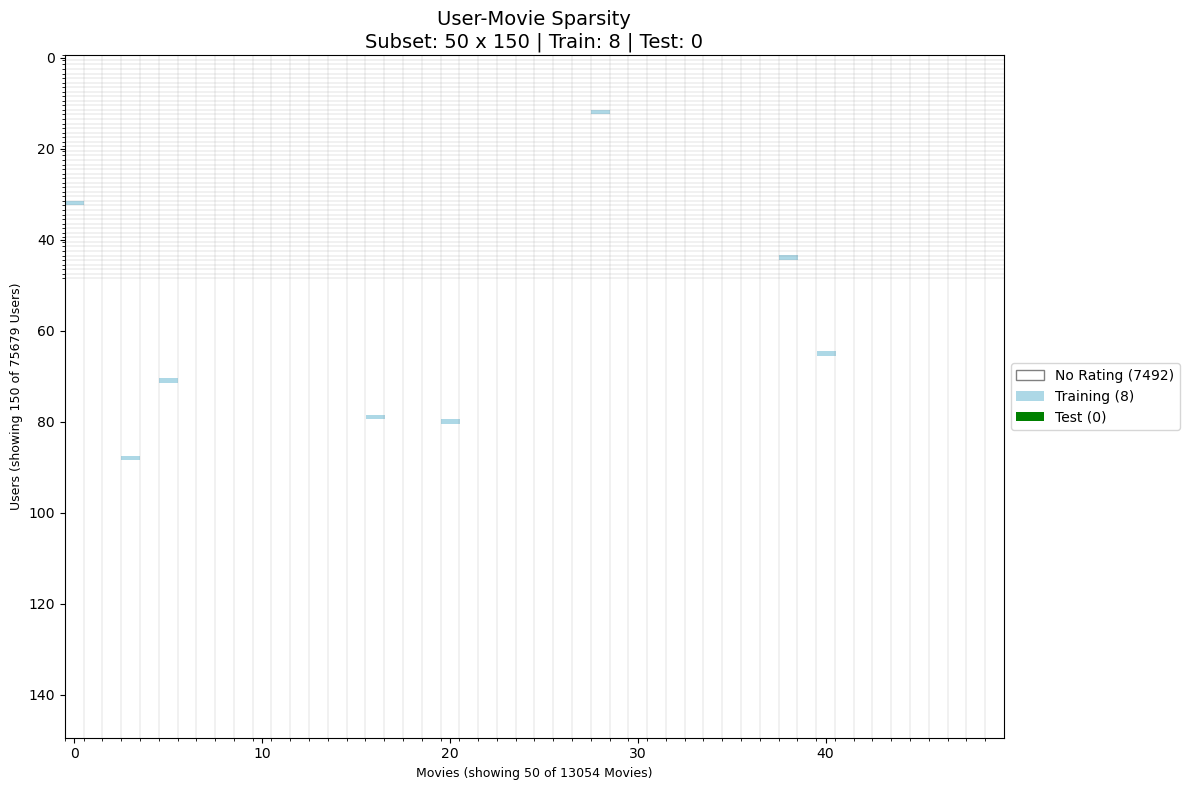

In [121]:
baseline_BIAS.create_rating_visualization(ratings_train_df,ratings_test_df ,ratings_df, 50, 50)

### Matrix Factorization Model

In [42]:
vanilla_MF_hyper_parameters_to_change = {
                            'learning_rate' : .01,           #most important
                            'n_factors' : 10,                #very important. As the matrix gets sparser, the n_factors should decrease for optimal fits
                                                             #without overfitting
                            'regularization' : .01,          #kind of important
                            'epochs' : 10,                   #not very important. Could probably get away with 5 epochs as well
                            'batch_size' : 1024              #least important-> likely won't improve the model much

}

################## Don't change anything else in this cell #################################
vanilla_MF = MF_Recommender(
                            n_factors = vanilla_MF_hyper_parameters_to_change['n_factors'] ,
                            learning_rate = vanilla_MF_hyper_parameters_to_change['learning_rate'] , 
                            regularization = vanilla_MF_hyper_parameters_to_change['regularization'] ,
                            epochs = vanilla_MF_hyper_parameters_to_change['epochs'] , 
                            batch_size = vanilla_MF_hyper_parameters_to_change['batch_size'] , 
                            use_bias= True,
                            MF_bias = False,
                            use_latent_features = True,
                            use_content_features= False
            )

updated_sparsity_ratings_df = vanilla_MF.set_sparsity(ratings_df, sparsity_hyper_param)
ratings_train_df, ratings_test_df = train_test_split(updated_sparsity_ratings_df, test_size = .2, random_state = 158)
tags_train_df, tags_test_df = train_test_split(tags_df, test_size = .2, random_state = 158)

Unique users: 75679, Unique Movies: 13054, Total Ratings: 150000
Current_density is 0.00015183513009526481
Achieved sparsity of  0.000142


In [43]:

vanilla_MF.fit_model(ratings_train_df, tags_train_df)

results = vanilla_MF.simple_evaluation(ratings_test_df)
print('\n')
print(f'Test Set Results: \n     RMSE: {results['rmse']:.4f} \n     MAE: {results['mae']: .4f}')
print(f'     Bias: {results['bias']:.4f} \n     Variance: {results['variance']: .4f}')
print(f'\n     Prediction Accuracy: \n     Within +- .5 stars {results['within_half_star']:.1f}% \n     Within +- 1 stars {results['within_one_star']:.1f}% \n')
print(f'     Coverage:\n     Valid Predictions: {results['coverage']:.1f}% ')

vanilla_MF.map_movie_to_names(movies_data[['movieId', 'title']])


precision_recall_results = vanilla_MF.Precision_And_Recall_At_K(ratings_test_df, ratings_train_df, num_recommendations = 5, relevance_threshold = 2.5, 
                                                                num_of_examples = 5 )
print('\n')
print(f'Precision is: {precision_recall_results['avg_precision']} and Recall is: {precision_recall_results['avg_recall']}')
for example in vanilla_MF.examples_list:
    print(f'Sample User Data')
    print(f'user Id: {example['userId']}')
    print(f'In Training Set: {example['in_train_set']: <10} In Test Set: {example['in_test_set']} In UserId to Idx: {example['in_userId_to_idx']}')
    print(f'User Precision: {example['precision']: <10} User Recall: {example['recall']}')
    print(f'User # of Hits: {example['num_of_hits']: <10} User # of Relevant In Test: {example['num_of_relevant_in_test']}')
    print(f'User # Movies Watched in Train: {example['num_movies_watched_in_train']}')
    print(f'User Top K Recommendations: {example['top_k_recommendations']}')
    print(f'User Relevant Movies in Test: {example['relevant_movies_in_test']}')
    print(f'User Sample of Movies Watched in Train: {example['sample_of_movies_watched_in_train']}')
    print('\n')

Training started with Mini Batch SGD (batch size=1024)
Data has 65518 Total Users, 11907 Total movies, and 10 K dimensions
Total Epochs is 10, Learning rate is 0.01, and 88 batches per epoch

Starting fit for epoch 1/10
Finished fitting Epoch 1
Starting fit for epoch 10/10
Finished fitting Epoch 10
Finished all Epochs. Total time elapsed  0.28 minutes
Finished fitting. Total time elapsed  0.30 minutes
Epoch 10/10: Training RMSE loss is  0.927564 and Validation RMSE loss is  0.960353
Training MAE loss is  0.719211 and Validation MAE loss is  0.752989


Test Set Results: 
     RMSE: 1.0083 
     MAE:  0.7885
     Bias: 3.5390 
     Variance:  0.6110

     Prediction Accuracy: 
     Within +- .5 stars 0.8% 
     Within +- 1 stars 2.4% 

     Coverage:
     Valid Predictions: 57.6% 
The sample of users we are looking at is {180257, 134664, 18355, 162741, 112984}. There are 5 total users in this sample
Finished 0 users out of 22999 with 0 missing users
Finished 10000 users out of 22999 with

### Testing the Matrix Factorization Model with different Density Values and HyperParameters: 14 hours Run Time

In [ ]:
iteration = 0
#sparsity_list = [0.00007900,0.00008720,0.00009540,0.00010360,0.00011180,0.00012000,0.00012820,0.00013640,0.00014462,0.00015183]
sparsity_list = [0.00007900,0.00015183]
#tags_train_df = None
learning_rates_list = [0.001, 0.02]
n_factors_list = [5, 30]
regularizations_list = [0.01, 0.1]
MF_results = {}
for sparsity in sparsity_list:
    for lr in learning_rates_list:
        for nf in n_factors_list:
            for reg in regularizations_list:

                print(f"Running iteration {iteration}: "
                      f"sparsity={sparsity}, lr={lr}, nf={nf}, reg={reg}")

               
                MF = MF_Recommender(
                    n_factors=nf,
                    learning_rate=lr,
                    regularization=reg,
                    epochs=10,
                    batch_size=1024,
                    use_bias=True,
                    MF_bias=False,
                    use_latent_features=True,
                    use_content_features=False
                )

                
                updated_sparsity_ratings_df = MF.set_sparsity(ratings_df, sparsity)
                ratings_train_df, ratings_test_df = train_test_split(updated_sparsity_ratings_df, test_size = .2, random_state = 158)

                

                
                MF.fit_model(ratings_train_df, tags_df=None)

                
                results = MF.simple_evaluation(ratings_test_df)
                MF.map_movie_to_names(movies_data[['movieId', 'title']])
                
                pr_results = MF.Precision_And_Recall_At_K(ratings_test_df, ratings_train_df, num_recommendations = 5, relevance_threshold = 2.5, 
                                                                num_of_examples = 5 )

                
                MF_results[iteration] = {
                    "sparsity": sparsity,
                    "learning_rate": lr,
                    "n_factors": nf,
                    "regularization": reg,
                    "RMSE": results["rmse"],
                    "MAE": results["mae"],
                    "Bias": results["bias"],
                    "Variance": results["variance"],
                    "Accuracy_half": results["within_half_star"],
                    "Accuracy_one": results["within_one_star"],
                    "Coverage": results["coverage"],
                    "Avg_Precision": pr_results["avg_precision"],
                    "Avg_Recall": pr_results["avg_recall"]
                }

                iteration += 1
MF_results_df = pd.DataFrame.from_dict(MF_results, orient="index")
display(MF_results_df)

## Output the Raw Matrix Factorization results to a CSV File

In [ ]:
MF_results_new = MF_results_df
MF_results_new.to_csv('Raw_MF_results.csv', index = False)

## Add (RMSE*, Avg_Precision*,Avg_Recall*, score) and Display the Matrix Factorization results

In [ ]:
max_rmse = MF_results_df['RMSE'].max()
MF_results_df['RMSE*'] = 1 - (MF_results_df['RMSE'] / max_rmse)


MF_results_df = MF_results_df.rename(columns={
    'Accuracy_half': 'Pred_Acc_.5',
    'Accuracy_one': 'Pred_Acc_1'
})


MF_results_df['Avg_Precision*'] = MF_results_df['Avg_Precision'] / MF_results_df['Avg_Precision'].max()
MF_results_df['Avg_Recall*'] = MF_results_df['Avg_Recall'] / MF_results_df['Avg_Recall'].max()

MF_results_df['score'] = MF_results_df['RMSE*'] + (
    (MF_results_df['Avg_Precision*'] + MF_results_df['Avg_Recall*']) / 2
)

display(MF_results_df)

In [ ]:
MF_results_new = MF_results_df
MF_results_new.to_csv('MF_results.csv', index = False)

### Spot Check if the user data in the Examples seems strange

In [ ]:
ratings_test_df[ratings_test_df['userId'] ==  146718]

In [ ]:
ratings_train_df[ratings_train_df['userId'] == 146718]

### Create Visualizations

In [ ]:
    def create_rating_visualization(self, training_set, test_set, 
                              predictions, full_dataset, subset_row_size: int, 
                              subset_col_size: int, figsize=(12, 8),
                              show_values=True):

        unique_users_in_order = sorted(full_dataset['userId'].unique())
        unique_movies_in_order = sorted(full_dataset['movieId'].unique())
        
        subset_users = unique_users_in_order[subset_row_size: subset_row_size + subset_row_size]
        subset_movies = unique_movies_in_order[subset_row_size: subset_row_size + subset_row_size]
    
        #build zeros matrix 
        matrix_viz = np.zeros((len(subset_users), len(subset_movies)))
    
        #color code based on values. 0 = no rating, 1 = training, 2 = tested prediction
        for _, row in training_set.iterrows():
            if row['userId'] in subset_users and row['movieId'] in subset_movies:
                u_idx = subset_users.index(row['userId'])
                m_idx = subset_movies.index(row['movieId'])
                matrix_viz[u_idx, m_idx] = 1
    
        for _, row in test_set.iterrows():
            if row['userId'] in subset_users and row['movieId'] in subset_movies:
                u_idx = subset_users.index(row['userId'])
                m_idx = subset_movies.index(row['movieId'])
                matrix_viz[u_idx, m_idx] = 2
    
    
        #make figure 
        fig, ax = plt.subplots(figsize = figsize)
    
        #set colors for matrix
        colors = ['white', 'lightblue', 'green']
        camp = ListedColormap(colors)
    
        #plot matrix
        im = ax.imshow(matrix_viz, cmap=cmap, aspect='auto', vmin=0, vmax=2)
    
        ax.set_xticks(np.arange(len(subset_movies))-.5, minor=True)
        ax.set_yticks(np.arange(len(subset_movies))-.5, minor=True)
        ax.grid(which='minor', color='gray',linstyle='-', linewidth=.3, alpha=.5)
    
        #labels
        ax.set_x_label(f'Movies (showing {len(subset_movies)} of {len(unique_users_in_order)}', fontsize=12)
        ax.set_y_label(f'Users (showing {len(subset_users)} of {len(unique_movies_in_order)}', fontsize=12)
    
        #get sparsity
        train_cells = np.sum(matrix_viz ==1)
        test_cells = np.sum(matrix_viz == 2)
        empty_cells = np.sum(matrix_viz ==0)
        total_cells = train_cells + test_cells + empty_cells
        sparsity = (1.0 * train_cells + test_cells)/total_cells
    
        #title
        ax.set_title(f'{title}\n'
                     f'Subset: {subset_rows} x {subset_cols} | '
                     f'Train: {train_cells} | Test: {test_cells} | '
                     f'Sparsity: {sparsity:.1%}', fontsize=14)
    
        legend_elements = [
            patches.Patch(facecolor='white', edgecolor='gray', label=f'No Rating ({empty_cells:.0f})'),
            patches.Patch(facecolor='lightblue', label=f'Training ({train_cells:.0f})'),
            patches.Patch(facecolor='green', label=f'Test ({test_cells:.0f})')
        ]
        ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
        plt.tight_layout()
        return fig, ax

### Read Results

In [144]:
results_data_path = data_path + 'MF_600_runs_results.csv' # the long 14 hour run results

results_DF = pd.read_csv(results_data_path)
results_DF['RMSE_updated'] = 1 - (results_DF['RMSE']/results_DF['RMSE'].max())
results_DF['Avg_Precision_updated'] = results_DF['Avg_Precision']/results_DF['Avg_Precision'].max()
results_DF['Avg_Recall_updated'] = results_DF['Avg_Recall']/results_DF['Avg_Recall'].max()
# Weighted Score .5(RMSE) + .25(Avg Precision) + .25(Avg Recall)
results_DF['Synthesized_Score'] = .5*results_DF['RMSE_updated'] + .25*results_DF['Avg_Precision_updated'] + .25*results_DF['Avg_Recall_updated']
results_DF = results_DF.rename(columns={results_DF.columns[0]: 'Result_Index'})
results_DF

,Result_Index,sparsity,learning_rate,n_factors,regularization,RMSE,MAE,Bias,Variance,Accuracy_half,Accuracy_one,Coverage,Avg_Precision,Avg_Recall,RMSE_updated,Avg_Precision_updated,Avg_Recall_updated,Synthesized_Score
0,0,0.000079,0.001,5,0.01,1.069496,0.855924,3.608411,0.571876,0.748513,2.293519,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.000079,0.001,5,0.05,1.069496,0.855924,3.608411,0.571876,0.748513,2.293519,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.000079,0.001,5,0.10,1.069496,0.855924,3.608411,0.571876,0.748513,2.293519,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000079,0.001,10,0.01,1.069496,0.855924,3.608411,0.571876,0.748513,2.293519,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.000079,0.001,10,0.05,1.069496,0.855924,3.608411,0.571876,0.748513,2.293519,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,0.000152,0.020,20,0.05,0.994034,0.778325,3.536954,0.635136,0.806694,2.210074,62.40208,0.000192,0.000899,0.070559,0.079545,0.075808,0.074118
596,596,0.000152,0.020,20,0.10,0.994034,0.778325,3.536954,0.635136,0.806694,2.210074,62.40208,0.000192,0.000899,0.070559,0.079545,0.075808,0.074118
597,597,0.000152,0.020,30,0.01,0.993791,0.778122,3.536617,0.635171,0.806694,2.210074,62.40208,0.000330,0.001543,0.070786,0.136364,0.130191,0.102032
598,598,0.000152,0.020,30,0.05,0.993791,0.778122,3.536617,0.635171,0.806694,2.210074,62.40208,0.000330,0.001543,0.070786,0.136364,0.130191,0.102032


In [165]:
sorted_scores_DF = results_DF.sort_values('Synthesized_Score', ascending=False)
top_models = sorted_scores_DF.drop_duplicates(subset=['sparsity'])
top_models = top_models[['Synthesized_Score', 'sparsity']]
top_idx = top_models.index
top_MF_DF = results_DF.loc[top_idx]
top_MF_DF

,Result_Index,sparsity,learning_rate,n_factors,regularization,RMSE,MAE,Bias,Variance,Accuracy_half,Accuracy_one,Coverage,Avg_Precision,Avg_Recall,RMSE_updated,Avg_Precision_updated,Avg_Recall_updated,Synthesized_Score
549,549,0.000152,0.001,30,0.01,1.030859,0.812395,3.553840,0.568807,0.805027,2.206740,62.402080,0.002416,0.011852,0.036126,1.000000,1.000000,0.518063
380,380,0.000128,0.002,20,0.10,1.029576,0.809535,3.556401,0.568292,0.825109,2.248322,50.165811,0.002048,0.010493,0.037326,0.847525,0.885305,0.451871
434,434,0.000136,0.002,5,0.10,1.031112,0.810870,3.551906,0.576202,0.801454,2.280064,54.580535,0.002024,0.010639,0.035890,0.837429,0.897613,0.451705
249,249,0.000112,0.001,30,0.01,1.060323,0.837306,3.562049,0.579438,0.864645,2.460389,38.085106,0.002016,0.011310,0.008577,0.834367,0.954206,0.451432
186,186,0.000104,0.001,20,0.01,1.054132,0.835517,3.569853,0.569569,0.803615,2.271617,30.034196,0.001965,0.011304,0.014366,0.812980,0.953696,0.448852
483,483,0.000145,0.001,10,0.01,1.034598,0.813535,3.550284,0.568768,0.804899,2.313211,59.415573,0.001960,0.009953,0.032630,0.811080,0.839775,0.429029
308,308,0.000120,0.001,20,0.10,1.041772,0.821487,3.559552,0.564109,0.790806,2.237453,45.428089,0.001764,0.009325,0.025923,0.729900,0.786747,0.392123
83,83,0.000087,0.002,30,0.10,1.058420,0.843701,3.593952,0.566203,0.734185,2.173535,11.839814,0.001461,0.010391,0.010357,0.604629,0.876689,0.375508
147,147,0.000095,0.005,10,0.01,1.054610,0.837307,3.575364,0.577309,0.787798,2.294430,22.143236,0.001463,0.009558,0.013918,0.605565,0.806424,0.359956
18,18,0.000079,0.002,20,0.01,1.069496,0.855924,3.608411,0.571876,0.748513,2.293519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Loading the Baseline Model results generated a few cells before

In [168]:
#bias_data_path = data_path + 'Bias_Recommender_results2.csv'
bias_data_path = data_path + 'Bias_Regularizaed_Recommender_results.csv'

biased_DF = pd.read_csv(bias_data_path)
biased_DF['RMSE_updated'] = 1 - (biased_DF['RMSE']/biased_DF['RMSE'].max())
biased_DF['Avg_Precision_updated'] = biased_DF['Avg Precision']/biased_DF['Avg Precision'].max()
biased_DF['Avg_Recall_updated'] = biased_DF['Avg Recall']/biased_DF['Avg Recall'].max()
biased_DF['Synthesized_Score'] = .5*biased_DF['RMSE_updated'] + .25*biased_DF['Avg_Precision_updated'] + .25*biased_DF['Avg_Recall_updated']
#biased_DF = biased_DF.rename(columns={biased_DF.columns[0]: 'Result_Index'})
biased_DF

,sparsity,RMSE,MAE,Bias,Variance,Pred_Acc_.5%,Pred_Acc_1%,Coverage,Avg Precision,Avg Recall,RMSE_updated,Avg_Precision_updated,Avg_Recall_updated,Synthesized_Score
0,0.000079,1.069479,0.855806,3.609214,0.571868,0.748513,2.293519,0.000000,0.000000,0.000000,0.046549,0.000000,0.000000,0.023275
1,0.000087,1.086471,0.863380,3.574205,0.637011,0.829948,2.382472,11.839814,0.000162,0.001701,0.031401,0.269639,0.384825,0.179317
2,0.000095,1.109387,0.874016,3.548003,0.701602,0.949602,2.649867,22.143236,0.000236,0.002156,0.010971,0.392016,0.487877,0.225459
3,0.000104,1.102913,0.868111,3.537657,0.739079,1.016121,2.747924,30.034196,0.000276,0.002338,0.016743,0.457962,0.528994,0.255110
4,0.000112,1.121693,0.877471,3.526076,0.783650,1.104572,2.971933,38.085106,0.000186,0.001526,0.000000,0.308444,0.345311,0.163439
5,0.000120,1.116998,0.870891,3.516045,0.802811,1.045972,2.840574,45.428089,0.000370,0.002682,0.004186,0.614840,0.606799,0.307503
6,0.000128,1.118625,0.869210,3.509857,0.817885,1.052112,2.838531,50.165811,0.000379,0.002641,0.002735,0.629932,0.597554,0.308239
7,0.000136,1.114070,0.866996,3.509077,0.835213,1.022226,2.845906,54.580535,0.000602,0.004419,0.006796,1.000000,1.000000,0.503398
8,0.000145,1.120767,0.867274,3.505092,0.857467,1.055118,2.923885,59.415573,0.000431,0.002899,0.000825,0.715191,0.655987,0.343207
9,0.000152,1.114512,0.862089,3.510483,0.865697,1.043368,2.845095,62.402080,0.000481,0.003309,0.006402,0.798160,0.748643,0.389902


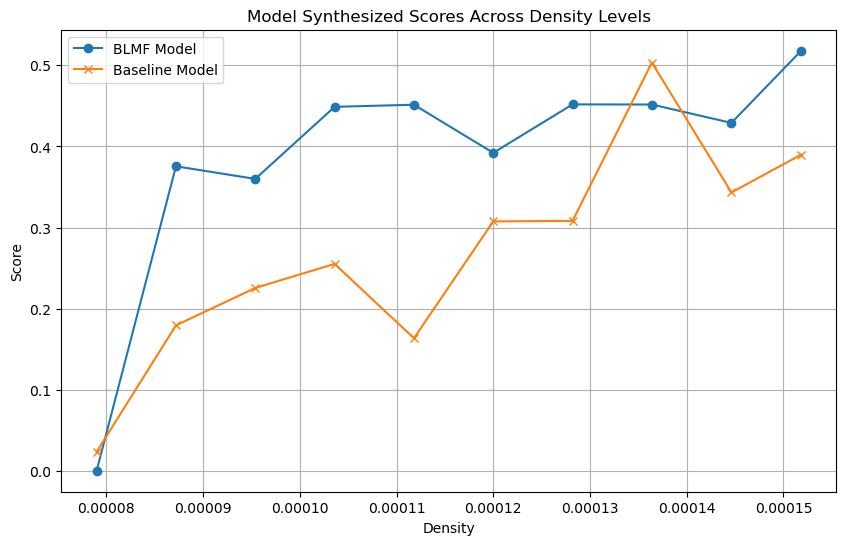

In [169]:
combined_DF = pd.merge(biased_DF, top_MF_DF, on='sparsity', suffixes=('_baseline', '_BLMF'))

plt.figure(figsize=(10,6))
plt.plot(
            combined_DF['sparsity'], 
            combined_DF['Synthesized_Score_BLMF'],
            label='BLMF Model',
            marker='o'
)

plt.plot(
           combined_DF['sparsity'], 
           combined_DF['Synthesized_Score_baseline'],
           label='Baseline Model',
           marker='x' 
)

plt.title('Model Synthesized Scores Across Density Levels')
plt.xlabel('Density')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

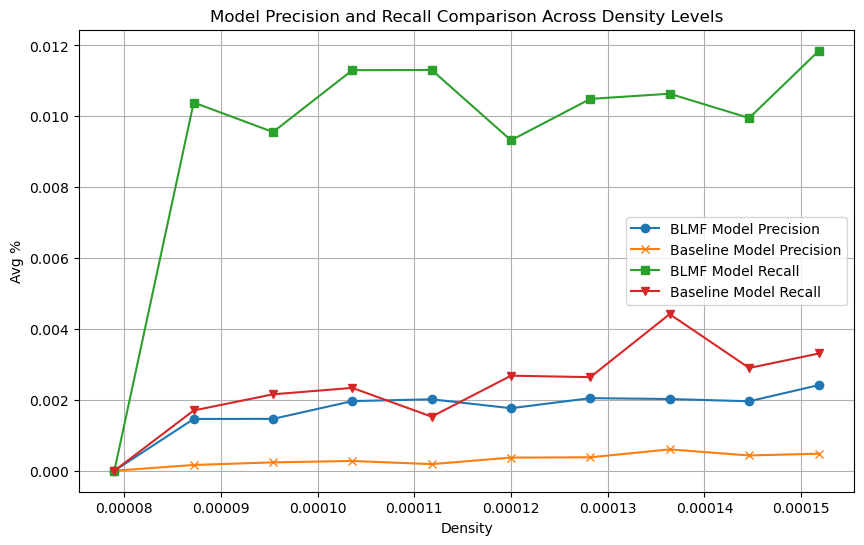

In [170]:
combined_DF = pd.merge(biased_DF, top_MF_DF, on='sparsity', suffixes=('_baseline', '_BLMF'))

plt.figure(figsize=(10,6))
plt.plot(
            combined_DF['sparsity'], 
            combined_DF['Avg_Precision'],
            label='BLMF Model Precision',
            marker='o'
)

plt.plot(
           combined_DF['sparsity'], 
           combined_DF['Avg Precision'],
           label='Baseline Model Precision',
           marker='x' 
)

plt.plot(
            combined_DF['sparsity'], 
            combined_DF['Avg_Recall'],
            label='BLMF Model Recall',
            marker='s'
)

plt.plot(
           combined_DF['sparsity'], 
           combined_DF['Avg Recall'],
           label='Baseline Model Recall',
           marker='v' 
)

plt.title('Model Precision and Recall Comparison Across Density Levels')
plt.xlabel('Density')
plt.ylabel('Avg %')
plt.legend()
plt.grid(True)

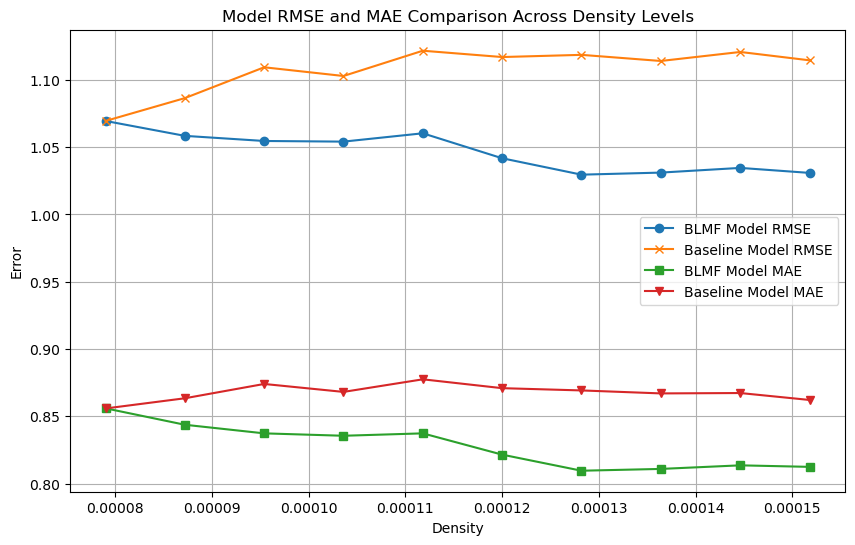

In [171]:
combined_DF = pd.merge(biased_DF, top_MF_DF, on='sparsity', suffixes=('_baseline', '_BLMF'))

plt.figure(figsize=(10,6))
plt.plot(
            combined_DF['sparsity'], 
            combined_DF['RMSE_BLMF'],
            label='BLMF Model RMSE',
            marker='o'
)

plt.plot(
           combined_DF['sparsity'], 
           combined_DF['RMSE_baseline'],
           label='Baseline Model RMSE',
           marker='x' 
)

plt.plot(
            combined_DF['sparsity'], 
            combined_DF['MAE_BLMF'],
            label='BLMF Model MAE',
            marker='s'
)

plt.plot(
           combined_DF['sparsity'], 
           combined_DF['MAE_baseline'],
           label='Baseline Model MAE',
           marker='v' 
)

plt.title('Model RMSE and MAE Comparison Across Density Levels')
plt.xlabel('Density')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

## Modified the cell code below to find the user that had a hit, everything else was commented out

In [ ]:
vanilla_MF.fit_model(ratings_train_df, tags_train_df)

#results = vanilla_MF.simple_evaluation(ratings_test_df)
#print('\n')
#print(f'Test Set Results: \n     RMSE: {results["rmse"]:.4f} \n     MAE: {results["mae"]: .4f}')
#print(f'     Bias: {results["bias"]:.4f} \n     Variance: {results["variance"]: .4f}')
#print(f'\n     Prediction Accuracy: \n     Within +- .5 stars {results["within_half_star"]:.1f}% \n     Within +- 1 stars {results["within_one_star"]:.1f}% \n')
#print(f'     Coverage:\n     Valid Predictions: {results["coverage"]:.1f}% ')

vanilla_MF.map_movie_to_names(movies_data[['movieId', 'title']])


precision_recall_results = vanilla_MF.Precision_And_Recall_At_K(ratings_test_df, ratings_train_df, num_recommendations = 10, relevance_threshold = 2.5, 
                                                                num_of_examples = 100 )
#print('\n')
print(f'Precision is: {precision_recall_results["avg_precision"]} and Recall is: {precision_recall_results["avg_recall"]}')
user_results={}
iteration = 0
for example in vanilla_MF.examples_list:
    if example["num_of_hits"]>0:
        user_results[iteration]={
            'User Id':example["userId"],
            'User # of Hits':example["num_of_hits"],
            'In Training Set':example["in_train_set"],
            'In Test Set':example["in_test_set"],
            'Precision':example["precision"],
            'User Recall':example["recall"],
            'User # Movies Watched in Train':example["num_movies_watched_in_train"],
            'User Top K Recommendations':example["top_k_recommendations"],
            'User Relevant Movies in Test':example["relevant_movies_in_test"],
            'User # of Relevant In Test':example["num_of_relevant_in_test"],
            'User Sample of Movies Watched in Train':example["sample_of_movies_watched_in_train"]
        }
        
        iteration += 1
user_results_df = pd.DataFrame.from_dict(user_results)
display(user_results_df)
 # print(f'Sample User Data')
 #        print(f'user Id: {example["userId"]}')
 #        print(f'In Training Set: {example["in_train_set"]: <10} In Test Set: {example["in_test_set"]} In UserId to Idx: {example["in_userId_to_idx"]}')
 #        print(f'User Precision: {example["precision"]: <10} User Recall: {example["recall"]}')
 #        print(f'User # of Hits: {example["num_of_hits"]: <10} User # of Relevant In Test: {example["num_of_relevant_in_test"]}')
 #        print(f'User # Movies Watched in Train: {example["num_movies_watched_in_train"]}')
 #        print(f'User Top K Recommendations: {example["top_k_recommendations"]}')
 #        print(f'User Relevant Movies in Test: {example["relevant_movies_in_test"]}')
 #        print(f'User Sample of Movies Watched in Train: {example["sample_of_movies_watched_in_train"]}')
 #        }   

In [ ]:
user_results_df=user_results_df.T
user_results_df['User Relevant Movies in Test'] = (
    user_results_df['User Relevant Movies in Test']
    .apply(lambda liist: [dic['movie_name'] for dic in liist] if isinstance(liist, list) else liist))

In [ ]:
pd.set_option('display.max_colwidth', 90)
user_results2